CMPE251: Data analytics is a course taught at Queen's University by Dr. David Skillicorn. This is the capstone project for the course
# CMPE251: Analysis of Adulterant in Drug Shipments

## Problem Definition 
### Project Background
As illicit drugs go from production to wholesale to street sale, dealers often add adulterant to the shipments to increase volume and thus their profits. These adulterants act as a fingerprint/breadcrumbs that can help law enforcement trace the drugs to their country of origin and the paths they take to the consumer. 

This dataset describes the chemical composition of the adulterants added to the drug shipments found by customes. Each row of the dataset describes a shipment and each column denotes one adulterant detected. 

### Project Goals 
1. Cluster the samples according to their adulterant pattern, and gain insights into the possible pathways by which the drugs arrived at countries borders.
2. Create model that can predict a shipment label from adulerant profile. 

Some insights that can be gained are:
1. How many clearly defined pathways exist
2. How many big players vs small players exist
3. How much overlap are there between pathways

### Assumptions/Considerations 
1. If multiple shipments have the same adulterant pattern, they were presumably sourced from the same place. 
2. If all the patterns are different, then pipelines are complex and overlapping. 
3. Though it is not explicitly mentioned, from project description, the drugs of concern here are illicit drugs. 
4. The accuracy/breadth of the data here depends on Customs ability to seize and test drugs, meaning that different pathways may be less/more covert in detection leading to over/under-representation in the data.
5. Without knowing the country in which the drugs were seized, we cannot get a full picture of the which pathways are more resilient to detection.


# First Look At Data
Let's take a first look at the data. In this step we'll first look at the shape of the data, a list of the adulterants in the set and their respective frequencies. 

In [64]:
# Dataset manipulation
import pandas as pd
import numpy as np

# Data visualization 
import matplotlib.pyplot as plt
%matplotlib inline 
import  seaborn as sns

#Clustering
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import DistanceMetric
import umap.umap_ as umap
import plotnine as p9

pd.set_option('display.max_rows', None)

df = pd.read_csv('./drugsamples.csv')
print(df.shape)
print(df.head())
print(df.columns)
print(df.dtypes)


(2474, 58)
  PROMIS_Seizure_SeizureName  Ecgonine  Benzoylecgonine  N_Formylcocaine  \
0                  PS3080497      0.05             0.11             0.02   
1                  PS3080497      0.02             0.08             0.02   
2                  PS3080497      0.03             0.08             0.01   
3                  PS3080497      0.04             0.10             0.01   
4                  PS3080497      0.02             0.07             0.01   

   Ecgonine_methyl_ester  Norcocaine  cis_Cinnamoylcocaine  \
0                   0.02        0.01                  0.07   
1                   0.03        0.01                  0.08   
2                   0.03        0.01                  0.08   
3                   0.03        0.01                  0.08   
4                   0.03        0.01                  0.08   

   trans_Cinnamoylcocaine  Percent_Truxilline  Trimethoxycocaine  ...  \
0                    0.18              2.5975               0.20  ...   
1            

We see that there are 2474 observations representing drug shipments seized and 58 columns, 57 representing the chemical adulterant tested for and one column named **PROMIS_Seizure_SeizureName**. At this point in the investigation, data collected in this column is unknown. It may represent an identifier of the location or batch of drug shipments seized. By the background information provided, Each observation represents a unique shipment seized, but we can see from the from the output below that many different observations share the same string value in the column. A quick google search of the column name resulted in no information given. **An education guess from the name of the feature is that it represents an identifier of the "seizure operation" in which shipments were seized. Meaning that multiple shipments may be seized in one "incident".** I will follow-up with the course instructors. 

**Following up with course TA, the "PROMIS_Seizure_SeizureName" indicates the seizure operation. Meaning there may be multiple containers in one seizure. Thus different observations with the same value in this column represent different samples of the same seizure.**

In terms of the values in the chemical adulterant columns, the unit of measurement is not given, from a quick glance, it appears that they represent percentages of chemical composition. This will be explored in the Exploratory data analysis section.

We can also see that all the values in our dataset are numerical values except for trhe the first string "PROMIS_Seizure_SeizureName"

In [2]:
print(df['PROMIS_Seizure_SeizureName'].value_counts())

PS3187838    121
PS3098390     93
PS3239679     88
PS3087542     62
PS3247872     44
            ... 
PS3255752      1
PS3163708      1
PS3163700      1
PS3167858      1
PS3336931      1
Name: PROMIS_Seizure_SeizureName, Length: 465, dtype: int64


# Exploratory Data Analysis
Now that we've taken a first qualitative look at the data to understand the skeleton the problem, we will now take a qualitative dive into the dataset. **The goals of this section are to**:
1. Investigate the values held in each column
2. Investigate the presence of missing values in the dataset
3. Understand some summary statistics of the dataset (measures of central tendancy)
4. Investigate the distribution of the different adulterants 
5. Investigate correlation between features
* Investigate correlation between PROMIS_Seizure_SeizureName and other features 

We will go through these objectives sequentially and summerize findings at the bottom

## Investigate the value of each column 
### Summary Statistics: Numerical Data
Here we will invetigate the values held by our PROMIS_Seizure_SeizureName column and our compound columns separately. We begin with the compound columns. 

In [3]:
# Get dataframe without the PROMIS_Seizure_SeizureName column, since the rest are the compound values we want to investigare
df_compounds = df.drop(columns='PROMIS_Seizure_SeizureName')
df_compounds['sum'] = df_compounds.sum(axis=1)
print('Max: ' + str(df_compounds['sum'].max()))
print('Min: ' + str(df_compounds['sum'].min()))
print('Mean: ' + str(df_compounds['sum'].mean()))

Max: 190.99259999999995
Min: 1.7289999999999999
Mean: 112.33602421180274


To test the initial assumption that these each column held compound percentage of full shipment, all the values in the each shipment were summed up (barring the PROMIS_Seizure_SeizureName). To prove that they were percentages, we were looking for the sum of all rows features to be close to either 1 or 100. Instead, they range from ~1.73 to ~190.99, discounting this theory. 

Another assumption can be that each column represents some measure of mass or volume or concentration of chemical in the sample taken. Thus the sum of the features for each row would equal the total mass/volume of a shipment. 

Below we look at the summary statistic of all of our features

In [9]:
#Outputs the summary statistics of the compound values sorted by descending mean
df.describe().transpose().sort_values('mean', ascending=False)

#Drop the columns with no representation (bottom 7)
df_compounds = df_compounds.drop(columns=['Theophylline', 'Thebaine', 'Strychnine', 'Ketamine', 'Dextromorphan','Creatinine', 'Quinine'])

Here the top 10 most common adulterants detected can be seen at the top of the dataframe. After that, the compound concentrations dip to the decimals and shrink rapidly. Interestingly, no trace of the bottom 7 drugs tested were detected in the 2474 samples taken, namingly:
* Theophylline
* Thebaine
* Strychnine
* Ketamine
* Dextromorphan
* Creatinine
* Quinine

Before removing these columns it is worth noting that their lack of representation still tells us two majors things of the data:
1. **Drugs routes that are known to cut their drugs with these compounds are not represented in the data meaning. That they may not be active in the drug trade or their methods of delivery are evading detection**
2. **If these compounds are found in future data (future seizures), it could suggest one or more of the following**:
    1. New players/routes are entering the game
    2. Methods of detection are capturing drug trafficking routes that previously evaded detection
    3. Pre-existing players are diversifying the way dilute the drugs

### Summary Statistics: Categorical Data
We'll now look at the summary statistics of the PROMIS_Seizure_SeizureName column.

In [11]:
df['PROMIS_Seizure_SeizureName'].describe()

count          2474
unique          465
top       PS3187838
freq            121
Name: PROMIS_Seizure_SeizureName, dtype: object

## Investigate Summary Statistics
1. Here we'll look at the mean, median and mode of each each feature
2. We'll rank the top 10 most common adulterant compounds
3. See how much correlation exists between seizure code and the compound

## Investigate Feature Distributions
Here we'll be plotting the seizure code and compound concentration distributions.

## Summary of Insights
1. The compound features do not represent a *percentage* of the shipment seized but may represent a portion of the mass/volume of the overall shipment.

### To Dos
* Reach out to data provider to inquire into the units represented in the data. 

# Clustering
Now we will work to cluster the data using various clustering techniques. This clustering analysis works on the assumption that **samples with similar chemical compositions share similar pathways**. Thus we can also assume the following about clusters: 
1. Different samples belonging to the same clusters may indicate that the samples had the same origin.
2. As we move outwards from the cluster centroid, points belonging to that cluster may have had the same or similar origins, but have taken different pathways to the place of seizure 
3. Two different clusters that overlap/intersect may denote a two different pathways that converge at some point
4. Big clusters may indicate a major drug pathway/big player
5. Small clusters/anomalies indicate smaller players


## K-Mediods Using Gower's Distance
Because we are using both the categorical "PROMIS_Seizure_SeizureName" feature and our other numerical features, we must use a clustering algorithm that can handle mixed data. The first of these is using K-medoids with the Gower's distance measure. It uses manhattan distance for numerical data. For categorical data, it one-hot encodes the categorical data and then Jaccardd distance is applied

/var/folders/8v/tfm9dw7x0jd8qnk5cwd61m9h0000gn/T/ipykernel_10929/1796272016.py:13: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
/var/folders/8v/tfm9dw7x0jd8qnk5cwd61m9h0000gn/T/ipykernel_10929/1796272016.py:13: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

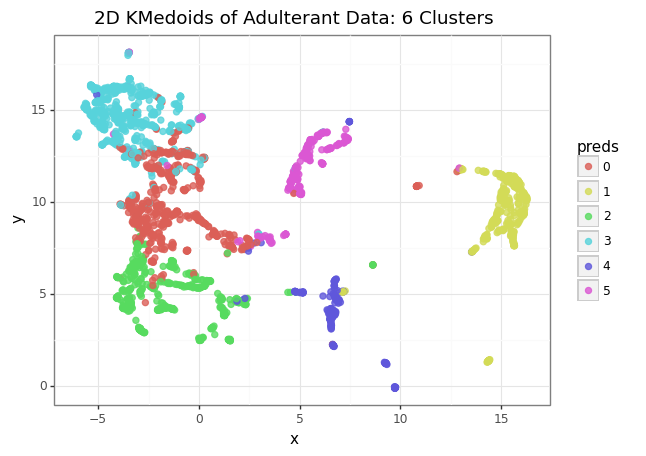

<ggplot: (321088847)>

In [48]:
def calculate_gower_distance(df):
  
  '''
  Takes a dataframe as an input and returns the gower distance
  matrix.
  
  '''

  variable_distances = []
  for col in range(df.shape[1]):
    
    feature = df.iloc[:,[col]]
    if feature.dtypes.values == np.object:
      
      feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature, drop_first=True))
        
    else:
      
      feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)


      variable_distances.append(feature_dist)
      

  return np.array(variable_distances).mean(0)



gower_data = df.copy()
gower_distance_matrix = calculate_gower_distance(gower_data)
umap.UMAP
umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(gower_distance_matrix)

gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

random_state = 32

#Begin with 7 clusters
gower_clusterer_6 = KMedoids(n_clusters=6, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(gower_distance_matrix)


gower_data["preds"] = gower_clusterer_6.labels_
gower_data["preds"] = gower_data["preds"].apply(str)
predictions = pd.DataFrame()
predictions['gower_preds'] = gower_clusterer_6.labels_

#Plot clusters
p1 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('2D KMedoids of Adulterant Data: 6 Clusters')
      + p9.theme_bw())

p1


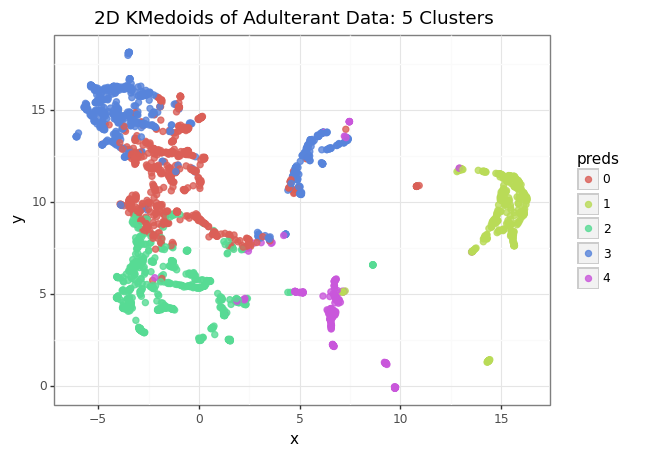

<ggplot: (322045431)>

In [50]:
#Repeat with 5 clusters
gower_clusterer_5 = KMedoids(n_clusters=5, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(gower_distance_matrix)


gower_data["preds"] = gower_clusterer_5.labels_
gower_data["preds"] = gower_data["preds"].apply(str)
predictions = pd.DataFrame()
predictions['gower_preds'] = gower_clusterer_5.labels_

p1 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('2D KMedoids of Adulterant Data: 5 Clusters')
      + p9.theme_bw())

p1

As we can see above, we've found 3 easily separable clusters to the middle-right of the above plot and 3 clusters to the left that do tend to show some overlap. 

Thus revisiting the original goal of the cluster analysis. Our plot above suggests **there are at least three drug pathways that are clearly distinct from others and eachother**. These are represented by the pink, purple and yellow clusters to the middle-right of the plot.

We can also see that there are three clusters to the left of the plot, represented by cyan, red and green dots that overlap at their extremities and are quite close in proximity to each other. This suggests that observations in these clusters may have similar origins and may have pathways that converge. Indeed these cluster may be subcluster to a bigger supercluster. To investigate this, the number of clusters were reduced, to see if those three clusters may indeed form a subcluster to a bigger "hidden" cluster. Surprisingly, setting the number of clusters to 5 resulted in one of our three "distinct clusters (the cluster previously pink), being assigned to one of the clusters to the left (cluster b). **This indicates that clusters 0, 2 and 3 are distinct with some overlap**. This also suggests that **there is some similarity between the upper-middle cluster and the top-left cluster that is not obvious when plotted in 2D.** 

 To further investigate this, we shall proceed with a hierarchical clustering. To see how the data is split in terms of similarity. This will give further insight into where pathways may diverge from the point of origin.

### Cluster Analysis
Below we will look at the statistics of the variables in each clusters and see what features are prominent intracluster and how they differ intercluster

In [67]:
#First let's group each cluster and find the median value across the board. In this case, we'll have to analyse the chemical compounds and seizure name separately
df_clustered_compounds = gower_data.drop(columns=["PROMIS_Seizure_SeizureName", "x", "y"])
df_clustered_compounds = df_clustered_compounds.groupby("preds").mean()

#Taking transpose makes it easier to grab compounds
df_clustered_compounds = df_clustered_compounds.transpose()

for i in range(0, 5):
    print("For cluster: " + str(i))
    print(df_clustered_compounds[str(i)].nlargest(n=10))


For cluster: 0
Ethyl_acetate         51.494931
nPropyl_acetate       16.898010
Toluene               13.276780
MEK                    9.954222
Levamisole             7.369069
Percent_Truxilline     6.444007
Benzene                2.383075
Isobutyl_acetate       2.112451
Dexamisole             1.596356
MP_Xylene              0.944591
Name: 0, dtype: float64
For cluster: 1
Acetone                   88.414549
Mesitylene                 3.177201
Methylisobutenylketone     2.639534
Ethyl_acetate              1.716767
Toluene                    1.634338
Sugar_Mannitol             1.281226
cis_Cinnamoylcocaine       0.873429
trans_Cinnamoylcocaine     0.852262
Phenacetin                 0.741420
Lignocaine                 0.704960
Name: 1, dtype: float64
For cluster: 2
nPropyl_acetate       71.144105
Ethyl_acetate          9.511830
Levamisole             7.707721
Toluene                6.512822
Percent_Truxilline     5.410991
MEK                    3.636957
Benzene                3.314761
Iso

The full results of the  can be seen in a text. Analysis of the these top ten featured compounds in each reveals much:
1. Clusters 0, 3, 4 have high concentrations of the compound Toluene (mean > 10). Suggesting that they have common origins or their paths intersect early on after being manufactured. [Further research](https://www.emcdda.europa.eu/publications/eu-drug-markets/cocaine/production_en]) reveals that **Toluene is commony used as a solvent to extract the cocaine from coca plants. It's prominance suggests that samples in these clusters consisted largely of cocaine and had their origins in the cocaine trade. Because cocaine is overwhelmingly trafficked out of South and Central America, I hypothesize that clusters 0, 3, and 4 have their origins in those regions of the world**
2. Cluster 1 samples contain an abundance of Acetone, [one of the raw ingrediants in making ecstasy](https://www.thermofisher.com/blog/identifying-threats/blue-barrels-of-acetone-leads-to-drug-arrest-in-the-netherlands/). **This reinforces the fact that this is a distinct cluster and suggests that a large presence of Acetone would be a good indicator that a future seizure belongs to this cluster/drug pathway


## Hierarchical Clustering

## Dimensionality Reduction (PCA)
Can use:
* Prince FAMD dimensionality reduction
* UMAP for dimension reduction 
## Summary of Insights

## TODO
* Look into the different features that denote the most similarity in a cluster


# Data Engineering
## Summary of Insights

# Model Building
## Summary of Insights

# Results
## Summary of Insights

# References
https://medium.com/codex/9-efficient-ways-for-describing-and-summarizing-a-pandas-dataframe-316234f46e6

https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

Mixed Data - KMedoid code copied and adapted from: https://github.com/Ekeany/Clustering-Mixed-Data
